In [66]:
"""
@Josh Boquiren
OTIS Lab MUSC
1.21.2023

README: 
- Revised version of "Population - PFC Self-Admin 7.2.ipynb"
- Better version for handling inactive data

POPULATION:
- Acquisition, active and inactive analysis
"""

'\n@Josh Boquiren\nOTIS Lab MUSC\n1.21.2023\n\nREADME: \n- Revised version of "Population - PFC Self-Admin 7.2.ipynb"\n- Better version for handling inactive data\n\nPOPULATION:\n- Acquisition, active and inactive analysis\n'

## Population Analysis

### Preprocessing

In [67]:
#import libraries

#data manipulation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#directory and file manager
import os

#statistics
import scipy.stats as stats
import scipy.io as sio
from sklearn.metrics import roc_auc_score as auROC
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples

# import subprocess
# import time
# import math
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC, SVR, LinearSVC
# from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
# from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.kernel_ridge import KernelRidge
# from sklearn import linear_model
# from sklearn.manifold import TSNE

# from scipy import interpolate

# import statsmodels.formula.api as smf
# from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)

# import matplotlib.cm as cm
# import matplotlib.colors as colors
# import matplotlib.colorbar as colorbar
# import matplotlib.patches as mpatches
# import sys
# import re
# import random
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# np.set_printoptions(suppress=True)


In [68]:
#initialize directories

population = 'ACQUISITION'

basedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data'

earlybasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/EarlyAcq'
middlebasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/MidAcq'
latebasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\LateAcq'

models = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\universal_models'

#for later plot titles
plot_titles = ['EARLY', 'MIDDLE', 'LATE']
population_title = "ACQ"

#animals of interest
early_animals_of_interest = [
    'CTL1',
    'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_of_interest = [
    'CTL1',
    'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6','LCDD-PGa1',
    'LCDD-PGa-T1','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5','LCDD-PGa-T2',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
late_animals_of_interest = [
    'CTL1',
     'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa3', 'LCDD-PGa4','LCDD-PGa5','LCDD-PGa6','LCDD-PGa1',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T5','LCDD-PGa-T4',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  

In [69]:
#frame rate variables
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging #raw frame rate
averagedframerate = timebetweenframes/frameaveraging #averaged frame rate

#window size variables
pre_window_size = int(10*framerate) #How many frames per trial before origin to be plotted?
window_size =  int((pre_window_size*2)+(3*framerate)) #How many frames do you want to plot around the origin?
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))

#set cell tracking
tracking = 'No' ### 'Yes' or 'No'
sorting = 'Yes' ### 'Yes' or 'No'
sorttoearly = 'No' ###'Yes' or 'No'; This is for sorting, but align to early data. 'Sorting' must also be Yes
csv_id_for_tracking = 'CUE-DRUG-TMT'

#tracking
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')

No Cell Tracking


In [70]:
#method for fixing dropped frames
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

#method for fixing assumed frames
def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

#generate behavior data
try:
    assumed_frames = np.load(os.path.join(models, 'assumed_frames.npy'))
    assumed_frame_timestamps = np.load(os.path.join(models, 'assumed_frame_timestamps.npy'))
    print("Loaded behavior data.")
except:
    #load in data
    behaviordata_noframes = sio.loadmat(r"C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\Spreadsheets\matfile_noframes_3.mat")
    eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

    #parse desired data
    max_of_eventlog_noframes = max(eventlog_noframes[:,1]) #all rows, second column
    length_of_eventlog_noframes = len(eventlog_noframes[:,1])
    x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
    x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
    x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)
    eventlog_noframes = x

    assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO

    np.save(os.path.join(models, 'assumed_frames'), assumed_frames)
    np.save(os.path.join(models, 'assumed_frames'), assumed_frame_timestamps)
    print("Behavior data processed and loaded.")


Loaded behavior data.


In [71]:
#various methods

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2


def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function ipltements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

In [72]:
#method for animal analysis
def analyze_single_session(indir, window_size, pre_window_size):    
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
        and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']

    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
            and 'extractedsignals_raw' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        if npyfile[0][0]!='nan':
            npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' 
            and not 'results' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numrois = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        if signals2[0][0]!='nan':
            signals = np.hstack((signals, signals2))
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        if signals3[0][0]!='nan':
            signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        if signals4[0][0]!='nan':
            signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    #pulling data from eventlog
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]    
    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T
    
    ###IF YOUR CODE LACKS FRAME INPUTS, WE CAN ATTEMPT TO PREDICT FRAME TIMING BY USING PREVIOUS FRAME TIMESTAMPS
    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1])
        
    frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    
    seconds_monitored = int(signals.shape[1]/averagedframerate) ###seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) ###final seconds to be monitored for behavior

    if seconds_monitored < seconds_behavior: #calculates last fully-monitored active lever press with 2p recording
        included_trials = []
        discarded_trials=[]
        for i in range(len(activelever)):
            if activelever[i]/1000<seconds_monitored:
                included_trials=np.append(included_trials, activelever[i])
            else:
                discarded_trials=np.append(discarded_trials,activelever[i])
        activelever=included_trials 
    
    #combines all presses
    activeleverall = np.hstack((activelever, activelevertimeout))
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))
    print('active = ', activeleverall.shape, '    inactive = ',inactiveleverall.shape )
 
    #method for calculating aligned data
    def calculate_aligneddata_forevent(data, frame_after_event):
        framenumberfor_eventofinterest = np.squeeze(framenumberforevent(frame_after_event, frame_timestamps))
        numtrials = framenumberfor_eventofinterest.shape[0]
        
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numrois])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numrois])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])
            
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    endindex = np.amin([framenumberfor_eventofinterest[i+1]-tempindex, tempendindex]).astype(int)
                else:
                    endindex = tempendindex.astype(int)  
                prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numrois))
                    align[i,:,:] = np.nan*np.ones((window_size, numrois))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))

        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0,0]))[0],:,:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
            
        return align, align_to_plot, framenumberfor_eventofinterest

    align_activelever, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall)  
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1
    
    align_inactivelever, align_to_plot_inactivelever, framenumberfor_frameafter_inactivelever = \
        calculate_aligneddata_forevent(signalsT, inactiveleverall)
    populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1
    
    for i in range(signals.shape[0]):
        if np.isnan(np.mean(signals[i,:])):
            print(animal, fov, 'IMAGE J ROI.ZIP CELL NUMBER %s HAS NaNs AND SHOULD BE CHANGED'%(i+1))
        
    return populationdata_activelever, populationdata_inactivelever, align_activelever, align_inactivelever, framerate

In [331]:
#creating analysis files for each mouse

print('POPULATION:', population)
#Early population
excluded = []
print('====== START: EARLY ======')
for animal in early_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        if "active_data.npy" in os.listdir(os.path.join(earlybasedir, animal, fov)) and "inactive_data.npy" in os.listdir(os.path.join(earlybasedir, animal, fov)):
            print('...Signal data files already exist!')
        if "aligned_active_lever_data.npy" in os.listdir(os.path.join(earlybasedir, animal, fov)) and "aligned_inactive_lever_data.npy" in os.listdir(os.path.join(earlybasedir, animal, fov)):
            print('...Aligned lever data files already exist!')
        else:
            temp_active_population = np.nan*np.ones((1, window_size)) 
            temp_inactive_population = np.nan*np.ones((1, window_size))
            temp_active_population_NaN = np.nan*np.ones((1, window_size))
            temp_inactive_population_NaN = np.nan*np.ones((1, window_size))
            FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
            for fov in sorted(FOVs):
                try:
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(earlybasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    #saving active signal data (excluding NaN rows)
                    if np.isnan(temp1[0][0]):
                        print('...NaN, will not stack!')
                        excluded.append(animal)
                    else:
                        temp_active_population = np.vstack((temp_active_population, temp1))
                    #saving inactive signal data (excluding NaN rows)
                    if np.isnan(temp2[0][0]):
                        print('...NaN, will not stack!')
                        excluded.append(animal)
                    else:
                        temp_inactive_population = np.vstack((temp_inactive_population, temp2))
                    #saving active and inactive signal data (includig NaN rows)
                    temp_active_population_NaN = np.vstack((temp_active_population_NaN, temp1))
                    temp_inactive_population_NaN = np.vstack((temp_inactive_population_NaN, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
                except:
                    print("***ERROR: animal data insufficient for processing!***")
                    excluded.append(animal)
            #files for signal data without NaN's
            np.save(os.path.join(earlybasedir, animal, fov, "active_data"), temp_active_population[1:,:])
            np.save(os.path.join(earlybasedir, animal, fov, "inactive_data"), temp_inactive_population[1:,:])

            #files for signal data with NaN's
            np.save(os.path.join(earlybasedir, animal, fov, "active_data_NaN"), temp_active_population_NaN[1:,:])
            np.save(os.path.join(earlybasedir, animal, fov, "inactive_data_NaN"), temp_inactive_population_NaN[1:,:])

            #files for aligned lever data
            np.save(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(earlybasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Early excluded animals:', excluded)
print('====== END: EARLY ======')

#Middle population
print('====== START: MIDDLE ======')
excluded = []
for animal in middle_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        if "active_data.npy" in os.listdir(os.path.join(middlebasedir, animal, fov)) and "inactive_data.npy" in os.listdir(os.path.join(middlebasedir, animal, fov)):
            print('...Active and inactive signal data files already exist!')
        if "aligned_active_lever_data.npy" in os.listdir(os.path.join(middlebasedir, animal, fov)) and "aligned_inactive_lever_data.npy" in os.listdir(os.path.join(middlebasedir, animal, fov)):
            print('...Active and inactive aligned lever data files already exist!')
        else:
            temp_active_population = np.nan*np.ones((1, window_size)) 
            temp_inactive_population = np.nan*np.ones((1, window_size))
            temp_active_population_NaN = np.nan*np.ones((1, window_size))
            temp_inactive_population_NaN = np.nan*np.ones((1, window_size))
            FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
            try:
                for fov in sorted(FOVs):
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(middlebasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    if np.isnan(temp1[0][0]):
                        print('...NaN, will not stack!')
                        excluded.append(animal)
                    else:
                        temp_active_population = np.vstack((temp_active_population, temp1))
                    #saving inactive signal data (excluding NaN rows)
                    if np.isnan(temp2[0][0]):
                        print('...NaN, will not stack!')
                        excluded.append(animal)
                    else:
                        temp_inactive_population = np.vstack((temp_inactive_population, temp2))
                    #saving active and inactive signal data (includig NaN rows)
                    temp_active_population_NaN = np.vstack((temp_active_population_NaN, temp1))
                    temp_inactive_population_NaN = np.vstack((temp_inactive_population_NaN, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
            except:
                print("***ERROR: animal data insufficient for processing!***")
                excluded.append(animal)
            #files for signal data without NaN's
            np.save(os.path.join(middlebasedir, animal, fov, "active_data"), temp_active_population[1:,:])
            np.save(os.path.join(middlebasedir, animal, fov, "inactive_data"), temp_inactive_population[1:,:])

            #files for signal data with NaN's
            np.save(os.path.join(middlebasedir, animal, fov, "active_data_NaN"), temp_active_population_NaN[1:,:])
            np.save(os.path.join(middlebasedir, animal, fov, "inactive_data_NaN"), temp_inactive_population_NaN[1:,:])

            #files for aligned lever data
            np.save(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(middlebasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Middle excluded animals:', excluded)
print('====== END: MIDDLE ======')

#Late population
print('====== START: LATE ======')
excluded = []
for animal in late_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        if "active_data.npy" in os.listdir(os.path.join(latebasedir, animal, fov)) and "inactive_data.npy" in os.listdir(os.path.join(latebasedir, animal, fov)):
            print('...Active and inactive signal data files already exist!')
        if "aligned_active_lever_data.npy" in os.listdir(os.path.join(latebasedir, animal, fov)) and "aligned_inactive_lever_data.npy" in os.listdir(os.path.join(latebasedir, animal, fov)):
            print('...Active and inactive aligned lever data files already exist!')
        else:
            temp_active_population = np.nan*np.ones((1, window_size)) 
            temp_inactive_population = np.nan*np.ones((1, window_size))
            temp_active_population_NaN = np.nan*np.ones((1, window_size))
            temp_inactive_population_NaN = np.nan*np.ones((1, window_size))
            FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
            for fov in sorted(FOVs):
                try:
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(latebasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    if np.isnan(temp1[0][0]):
                        print('...NaN, will not stack!')
                        excluded.append(animal)
                    else:
                        temp_active_population = np.vstack((temp_active_population, temp1))
                    #saving inactive signal data (excluding NaN rows)
                    if np.isnan(temp2[0][0]):
                        print('...NaN, will not stack!')
                        excluded.append(animal)
                    else:
                        temp_inactive_population = np.vstack((temp_inactive_population, temp2))
                    #saving active and inactive signal data (includig NaN rows)
                    temp_active_population_NaN = np.vstack((temp_active_population_NaN, temp1))
                    temp_inactive_population_NaN = np.vstack((temp_inactive_population_NaN, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
                except:
                    print("***ERROR: animal data insufficient for processing!***")
                    excluded.append(animal)
            #files for signal data without NaN's
            np.save(os.path.join(latebasedir, animal, fov, "active_data"), temp_active_population[1:,:])
            np.save(os.path.join(latebasedir, animal, fov, "inactive_data"), temp_inactive_population[1:,:])

            #files for signal data with NaN's
            np.save(os.path.join(latebasedir, animal, fov, "active_data_NaN"), temp_active_population_NaN[1:,:])
            np.save(os.path.join(latebasedir, animal, fov, "inactive_data_NaN"), temp_inactive_population_NaN[1:,:])

            #files for aligned lever data
            np.save(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(latebasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Late excluded animals:', excluded)
print('====== END: LATE ======')


POPULATION: ACQUISITION
====== START: EARLY ======
>>> CTL1
...Processing...
active =  (11,)     inactive =  (146,)
...Processing finished!
Excluded animals: []
>>> ER-L2
...Processing...
active =  (16,)     inactive =  (0,)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_16364\1388173365.py:180: RuntimeWarning: Mean of empty slice
  populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1


...NaN, will not stack!
...Processing finished!
Excluded animals: ['ER-L2']
>>> ER-L1
...Processing...
active =  (15,)     inactive =  (0,)
...NaN, will not stack!
...Processing finished!
Excluded animals: ['ER-L2', 'ER-L1']
>>> IG-19
...Processing...
active =  (77,)     inactive =  (0,)
...NaN, will not stack!
...Processing finished!
Excluded animals: ['ER-L2', 'ER-L1', 'IG-19']
>>> LCDD-PGa1
...Processing...
active =  (16,)     inactive =  (0,)
...NaN, will not stack!
...Processing finished!
Excluded animals: ['ER-L2', 'ER-L1', 'IG-19', 'LCDD-PGa1']
>>> LCDD-PGa3
...Processing...
active =  (17,)     inactive =  (0,)
...NaN, will not stack!
...Processing finished!
Excluded animals: ['ER-L2', 'ER-L1', 'IG-19', 'LCDD-PGa1', 'LCDD-PGa3']
>>> LCDD-PGa4
...Processing...
active =  (11,)     inactive =  (0,)
...NaN, will not stack!
...Processing finished!
Excluded animals: ['ER-L2', 'ER-L1', 'IG-19', 'LCDD-PGa1', 'LCDD-PGa3', 'LCDD-PGa4']
>>> LCDD-PGa5
...Processing...
active =  (15,)     in

In [332]:
#checking shapes of files

temp_arr = []

for animal in early_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(earlybasedir, animal, fov, "active_data.npy"))
                inactive_data = np.load(os.path.join(earlybasedir, animal, fov, "inactive_data.npy"))
                active_data_NaN = np.load(os.path.join(earlybasedir, animal, fov, "active_data_NaN.npy"))
                inactive_data_NaN = np.load(os.path.join(earlybasedir, animal, fov, "inactive_data_NaN.npy"))
                aligned_active_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'EARLY',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive_data.shape,
                    'Active NaN shape': active_data_NaN.shape,
                    'Inactive NaN shape': inactive_data_NaN.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

for animal in middle_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(middlebasedir, animal, fov, "active_data.npy"))
                inactive_data = np.load(os.path.join(middlebasedir, animal, fov, "inactive_data.npy"))
                active_data_NaN = np.load(os.path.join(middlebasedir, animal, fov, "active_data_NaN.npy"))
                inactive_data_NaN = np.load(os.path.join(middlebasedir, animal, fov, "inactive_data_NaN.npy"))
                aligned_active_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'MIDDLE',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive_data.shape,
                    'Active NaN shape': active_data_NaN.shape,
                    'Inactive NaN shape': inactive_data_NaN.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

for animal in late_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(latebasedir, animal, fov, "active_data.npy"))
                inactive_data = np.load(os.path.join(latebasedir, animal, fov, "inactive_data.npy"))
                active_data_NaN = np.load(os.path.join(latebasedir, animal, fov, "active_data_NaN.npy"))
                inactive_data_NaN = np.load(os.path.join(latebasedir, animal, fov, "inactive_data_NaN.npy"))
                aligned_active_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'LATE',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive_data.shape,
                    'Active NaN shape': active_data_NaN.shape,
                    'Inactive NaN shape': inactive_data_NaN.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

animal_df = pd.DataFrame(temp_arr)
animal_df

>>> CTL1
>>> ER-L2
>>> ER-L1
>>> IG-19
>>> LCDD-PGa1
>>> LCDD-PGa3
>>> LCDD-PGa4
>>> LCDD-PGa5
>>> LCDD-PGa6
>>> LCDD-PGa-T1
>>> LCDD-PGa-T2
>>> LCDD-PGa-T3
>>> LCDD-PGa-T4
>>> LCDD-PGa-T5
>>> PGa-T1
>>> PGa-T2
>>> PGa-T3
>>> CTL1
>>> ER-L2
>>> ER-L1
>>> IG-19
>>> LCDD-PGa3
>>> LCDD-PGa4
>>> LCDD-PGa5
>>> LCDD-PGa6
>>> LCDD-PGa1
>>> LCDD-PGa-T1
>>> LCDD-PGa-T3
>>> LCDD-PGa-T4
>>> LCDD-PGa-T5
>>> LCDD-PGa-T2
>>> PGa-T1
>>> PGa-T2
>>> PGa-T3
>>> CTL1
>>> ER-L2
>>> ER-L1
>>> IG-19
>>> LCDD-PGa3
>>> LCDD-PGa4
>>> LCDD-PGa5
>>> LCDD-PGa6
>>> LCDD-PGa1
>>> LCDD-PGa-T1
>>> LCDD-PGa-T2
>>> LCDD-PGa-T3
>>> LCDD-PGa-T5
>>> LCDD-PGa-T4
>>> PGa-T1
>>> PGa-T2
>>> PGa-T3


,Animal,Day,Active shape,Inactive shape,Active NaN shape,Inactive NaN shape,Aligned active shape,Aligned inactive shape
0,CTL1,EARLY,"(112, 190)","(112, 190)","(112, 190)","(112, 190)","(11, 190, 112)","(146, 190, 112)"
1,ER-L2,EARLY,"(91, 190)","(0, 190)","(91, 190)","(91, 190)","(16, 190, 91)","(0, 190, 91)"
2,ER-L1,EARLY,"(224, 190)","(0, 190)","(224, 190)","(224, 190)","(15, 190, 224)","(0, 190, 224)"
3,IG-19,EARLY,"(85, 190)","(0, 190)","(85, 190)","(85, 190)","(77, 190, 85)","(0, 190, 85)"
4,LCDD-PGa1,EARLY,"(19, 190)","(0, 190)","(19, 190)","(19, 190)","(16, 190, 19)","(0, 190, 19)"
5,LCDD-PGa3,EARLY,"(206, 190)","(0, 190)","(206, 190)","(206, 190)","(17, 190, 206)","(0, 190, 206)"
6,LCDD-PGa4,EARLY,"(105, 190)","(0, 190)","(105, 190)","(105, 190)","(11, 190, 105)","(0, 190, 105)"
7,LCDD-PGa5,EARLY,"(304, 190)","(0, 190)","(304, 190)","(304, 190)","(15, 190, 304)","(0, 190, 304)"
8,LCDD-PGa6,EARLY,"(100, 190)","(0, 190)","(100, 190)","(100, 190)","(22, 190, 100)","(0, 190, 100)"
9,LCDD-PGa-T1,EARLY,"(107, 190)","(0, 190)","(107, 190)","(107, 190)","(6, 190, 107)","(0, 190, 107)"


### Plotting population data

In [333]:
#stacking the data

print('POPULATION:', population,'\n')

#use files that exclude NaN's
active_data_file = "active_data.npy"
inactive_data_file = "inactive_data.npy"

#set num presses criteria
required_presses = 5

print('====== START: EARLY ======')
#initializes np array to stack on top of
population_data_active = np.nan*np.ones((1, window_size))
population_data_inactive = np.nan*np.ones((1, window_size))
dict_temp = []
dict_temp_usable = []
early_animals_used = []
for animal in early_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(earlybasedir, animal, fov, active_data_file))
                inactive_data = np.load(os.path.join(earlybasedir, animal, fov, inactive_data_file))
                aligned_active_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                active_presses = aligned_active_lever_data.shape[0]
                inactive_presses = aligned_inactive_lever_data.shape[0]
                dict_temp.append({'Day': plot_titles[0], 'Animal': animal, 'Neurons': aligned_active_lever_data.shape[2], 'Active presses': active_presses, 'Inactive presses': inactive_presses})
                #stack data
                if inactive_presses>required_presses:
                        population_data_active = np.vstack((population_data_active, active_data))
                        population_data_inactive = np.vstack((population_data_inactive, inactive_data))
                        dict_temp_usable.append({'Day': plot_titles[0], 'Animal': animal, 'Neurons': aligned_active_lever_data.shape[2], 'Active presses': active_presses, 'Inactive presses': inactive_presses})
                        early_animals_used.append(animal)
                else:
                        print('...Insufficient inactive presses, will not stack.')
        except:
               print('***ERROR: no files!***')

#num neurons is length of data - 1
numneurons_early_active = population_data_active.shape[0]-1 
numneurons_early_inactive = population_data_inactive.shape[0]-1 

#slices population data to not include first row
population_data_active = population_data_active[1:,:]
population_data_inactive = population_data_inactive[1:,:]

#calculating population active data - baseline
baseline = np.nanmean(population_data_active[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = population_data_active - baseline[:,None]

#calculating population inactive data - baseline
baseline = np.nanmean(population_data_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = population_data_inactive - baseline[:,None]

#other variables
numrois_early_active = pop_active.shape[0]
tempresponse = np.nanmean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_active = np.argsort(tempresponse)[::-1]
numrois_early_inactive = pop_inactive.shape[0]
tempresponse = np.nanmean(pop_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_inactive = np.argsort(tempresponse)[::-1]

#creating new variables for combined early active and inactive data because pop_active/pop_inactive will be overwritten
early_active = pop_active
early_inactive = pop_inactive

#calculating the mean using pandas
early_active_mean = np.nanmean(early_active, axis=0)
early_inactive_mean = np.nanmean(early_inactive, axis=0)

print('Early active shape:', early_active.shape)
print('Early inactive shape:', early_inactive.shape)
print('====== END: EARLY ======')

print('====== START: MIDDLE ======')
#initializes np array to stack on top of
population_data_active = np.nan*np.ones((1, window_size))
population_data_inactive = np.nan*np.ones((1, window_size))
middle_animals_used = []
for animal in middle_animals_of_interest:
        print('>>>', animal)
        FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
        for fov in sorted(FOVs):
                try:
                        #load in data
                        active_data = np.load(os.path.join(middlebasedir, animal, fov, active_data_file))
                        inactive_data = np.load(os.path.join(middlebasedir, animal, fov, inactive_data_file))
                        aligned_active_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data.npy"))
                        aligned_inactive_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                        active_presses = aligned_active_lever_data.shape[0]
                        inactive_presses = aligned_inactive_lever_data.shape[0]
                        dict_temp.append({'Day': plot_titles[1], 'Animal': animal, 'Neurons': aligned_active_lever_data.shape[2], 'Active presses': active_presses, 'Inactive presses': inactive_presses})
                        #stack data
                        if inactive_presses>required_presses:
                                population_data_active = np.vstack((population_data_active, active_data))
                                population_data_inactive = np.vstack((population_data_inactive, inactive_data))
                                dict_temp_usable.append({'Day': plot_titles[1], 'Animal': animal, 'Neurons': aligned_active_lever_data.shape[2], 'Active presses': active_presses, 'Inactive presses': inactive_presses})
                                middle_animals_used.append(animal)
                        else:
                                print('...Insufficient inactive presses, will not stack.')
                except:
                       print('***ERROR: no files!***')

#num neurons is length of data - 1
numneurons_middle_active = population_data_active.shape[0]-1 
numneurons_middle_inactive = population_data_inactive.shape[0]-1 

#slices population data to not include first row
population_data_active = population_data_active[1:,:]
population_data_inactive = population_data_inactive[1:,:]

#calculating population active data - baseline
baseline = np.mean(population_data_active[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = population_data_active - baseline[:,None]

#calculating population inactive data - baseline
baseline = np.mean(population_data_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = population_data_inactive - baseline[:,None]

#other variables
numrois_middle = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_active = np.argsort(tempresponse)[::-1]
numrois_middle_inactive = pop_inactive.shape[0]
tempresponse = np.nanmean(pop_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_inactive = np.argsort(tempresponse)[::-1]

#creating new variables for combined early active and inactive data because pop_active/pop_inactive will be overwritten
middle_active = pop_active
middle_inactive = pop_inactive

#calculating the mean using pandas
middle_active_mean = pd.DataFrame(middle_active).mean(axis=0)
middle_inactive_mean = pd.DataFrame(middle_inactive).mean(axis=0)

print('Middle active shape:', middle_active.shape)
print('Middle inactive shape:', middle_inactive.shape)
print('====== END: MIDDLE ======')

print('====== START: LATE ======')
#initializes np array to stack on top of
population_data_active = np.nan*np.ones((1, window_size))
population_data_inactive = np.nan*np.ones((1, window_size))
late_animals_used = []
for animal in late_animals_of_interest:
        print('>>>', animal)
        FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
        for fov in sorted(FOVs):
                try:
                        #load in data
                        active_data = np.load(os.path.join(latebasedir, animal, fov, active_data_file))
                        inactive_data = np.load(os.path.join(latebasedir, animal, fov, inactive_data_file))
                        aligned_active_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data.npy"))
                        aligned_inactive_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                        active_presses = aligned_active_lever_data.shape[0]
                        inactive_presses = aligned_inactive_lever_data.shape[0]
                        dict_temp.append({'Day': plot_titles[2], 'Animal': animal, 'Neurons': aligned_active_lever_data.shape[2], 'Active presses': active_presses, 'Inactive presses': inactive_presses})
                        #stack data
                        if inactive_presses>required_presses:
                                population_data_active = np.vstack((population_data_active, active_data))
                                population_data_inactive = np.vstack((population_data_inactive, inactive_data))
                                dict_temp_usable.append({'Day': plot_titles[2], 'Animal': animal, 'Neurons': aligned_active_lever_data.shape[2], 'Active presses': active_presses, 'Inactive presses': inactive_presses})
                                late_animals_used.append(animal)
                        else:
                                print('...Insufficient inactive presses, will not stack.')
                except:
                       print('***ERROR: no files!***')

#num neurons is length of data - 1
numneurons_late_active = population_data_active.shape[0]-1 
numneurons_late_inactive = population_data_inactive.shape[0]-1 

#slices population data to not include first row
population_data_active = population_data_active[1:,:]
population_data_inactive = population_data_inactive[1:,:]

#calculating population active data - baseline
baseline = np.mean(population_data_active[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = population_data_active - baseline[:,None]

#calculating population inactive data - baseline
baseline = np.mean(population_data_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = population_data_inactive - baseline[:,None]

#other variables
numrois_late = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late_active = np.argsort(tempresponse)[::-1]
numrois_late_inactive = pop_inactive.shape[0]
tempresponse = np.nanmean(pop_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late_inactive = np.argsort(tempresponse)[::-1]

#creating new variables for combined early active and inactive data because pop_active/pop_inactive will be overwritten
late_active = pop_active
late_inactive = pop_inactive

#calculating the mean using pandas
late_active_mean = pd.DataFrame(late_active).mean(axis=0)
late_inactive_mean = pd.DataFrame(late_inactive).mean(axis=0)

print('Late active shape:', late_active.shape)
print('Late inactive shape:', late_inactive.shape)
print('====== END: LATE ======')

POPULATION: ACQUISITION 

====== START: EARLY ======
>>> CTL1
>>> ER-L2
...Insufficient inactive presses, will not stack.
>>> ER-L1
...Insufficient inactive presses, will not stack.
>>> IG-19
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa1
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa3
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa4
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa5
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa6
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa-T1
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa-T2
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa-T3
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa-T4
...Insufficient inactive presses, will not stack.
>>> LCDD-PGa-T5
...Insufficient inactive presses, will not stack.
>>> PGa-T1
>>> PGa-T2
>>> PGa-T3
Early active shape: (614, 190)
Early inactive shape: (614, 190)
====== END:

In [94]:
#dataframe of all animals
df_all = pd.DataFrame(dict_temp)
df_all

,Day,Animal,Neurons,Active presses,Inactive presses
0,EARLY,CTL1,112,11,146
1,EARLY,ER-L2,91,16,0
2,EARLY,ER-L1,224,15,0
3,EARLY,IG-19,224,15,0
4,EARLY,LCDD-PGa1,19,16,0
5,EARLY,LCDD-PGa3,206,17,0
6,EARLY,LCDD-PGa4,105,11,0
7,EARLY,LCDD-PGa5,304,15,0
8,EARLY,LCDD-PGa6,100,22,0
9,EARLY,LCDD-PGa-T1,107,6,0


,Day,Animal,Neurons,Active presses,Inactive presses
0,EARLY,CTL1,112,11,146
1,EARLY,PGa-T1,286,22,146
2,EARLY,PGa-T2,99,17,81
3,EARLY,PGa-T3,117,14,49
4,MIDDLE,CTL1,158,80,44
5,MIDDLE,IG-19,95,115,7
6,MIDDLE,LCDD-PGa3,216,16,9
7,MIDDLE,LCDD-PGa5,123,26,18
8,MIDDLE,PGa-T1,240,197,270
9,MIDDLE,PGa-T2,165,244,237


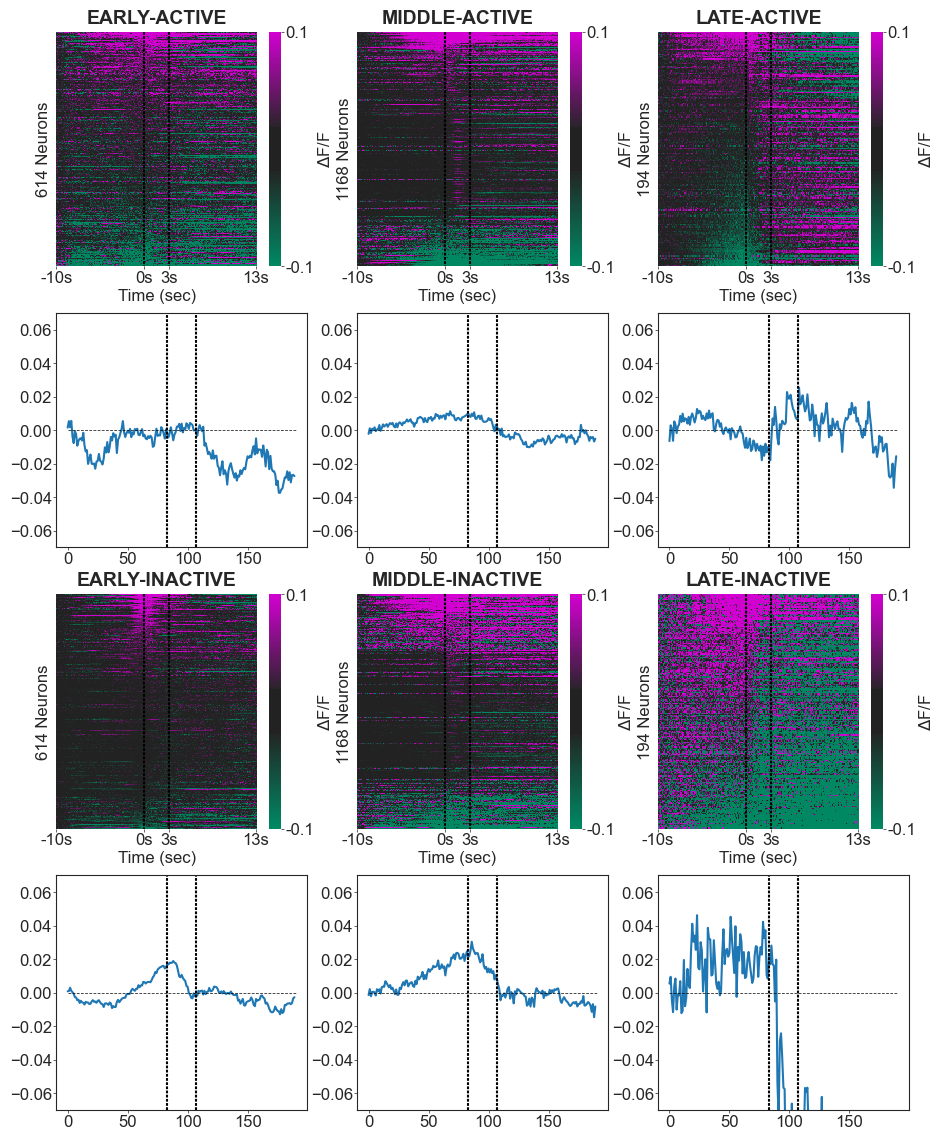

In [334]:
# plot and dataframe of used animals

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(early_active[sortresponse_early_active, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_early_active], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_early_active], '--k', linewidth=1.5)

# line plot
ax = axs[1, 0]
ax.plot(early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# early inactive plots
ax = axs[2, 0]

# heatmap
hm = sns.heatmap(early_inactive[sortresponse_early_inactive, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_early_inactive, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_early_inactive], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_early_inactive], '--k', linewidth=1.5)

# line plot
ax = axs[3, 0]
ax.plot(early_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(middle_active[sortresponse_middle_active, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_middle], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_middle], '--k', linewidth=1.5)

# line plot
ax = axs[1, 1]
ax.plot(middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# middle inactive plots
ax = axs[2, 1]

# heatmap
hm = sns.heatmap(middle_inactive[sortresponse_middle_inactive, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_middle_inactive, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_middle], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_middle], '--k', linewidth=1.5)

# line plot
ax = axs[3, 1]
ax.plot(middle_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# late active plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(late_active[sortresponse_late_active, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_late_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_late], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_late], '--k', linewidth=1.5)

# line plot
ax = axs[1, 2]
ax.plot(late_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# late inactive plots
ax = axs[2, 2]

# heatmap
hm = sns.heatmap(late_inactive[sortresponse_late_inactive, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_late_inactive, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_late], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_late], '--k', linewidth=1.5)

# line plot
ax = axs[3, 2]
ax.plot(late_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# dataframe of usable animals (no NaN's)
df_usable = pd.DataFrame(dict_temp_usable)
df_usable


## Cluster Analysis

### Creating cluster models

In [317]:
#import libraries

import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
from scipy import interpolate
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)

import matplotlib.pyplot as plt

In [335]:
#combine data across sets
new_active = np.vstack((early_active, middle_active, late_active, early_inactive, middle_inactive, late_inactive)) 
print('New active data shape:', new_active.shape)

#new_inactive = np.vstack((early_inactive, middle_inactive, late_inactive)) 
#print('New inactive data shape:', new_inactive.shape)

New active data shape: (3952, 190)


In [336]:
#select data that you want to analyze 
populationdata = new_active

print (populationdata.shape, 'array for clustering')

numneurons = populationdata.shape[0]
populationdata_nan_excluded = np.nan*np.ones((1, window_size))

for i in range(numneurons):
    if np.mean(populationdata[i,:]) < 1000:
        populationdata_nan_excluded = np.vstack((populationdata_nan_excluded,populationdata[i]))
populationdata_nan_excluded = populationdata_nan_excluded[1:,:]

print('Original population data shape:', populationdata.shape, '\nNew population data shape:', populationdata_nan_excluded.shape)
    
sortwindow = [pre_window_size, infusionframe] #sort responses between CS+ onset and reward
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1] #corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.1 # Maximum colormap value. 

trial_types = ['Active-Inactive'] #FIXME - add inactive?
    
populationdata = populationdata[:,(pre_window_size - int(3*framerate)):(pre_window_size + int(6*framerate))]

(3952, 190) array for clustering
Original population data shape: (3952, 190) 
New population data shape: (3952, 190)


In [320]:
#plot parameters

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['lines.scale_dashes'] = False
plt.rcParams['lines.dashed_pattern'] = (2, 1)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.color'] = 'k'
sns.set_style('ticks')

C:\Users\jboqu\AppData\Local\Temp\ipykernel_16364\510226586.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


(3952, 73)


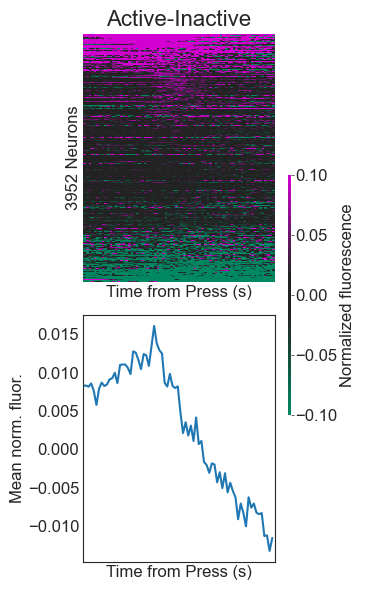

In [337]:
#plotting combined data

fig, axs = plt.subplots(2,len(trial_types),figsize=(3.3,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    axs[t].set_title(trial_types[t])
    ax = axs[0]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'},
                yticklabels=False)
    ax.grid(False)
    ax.tick_params(width=0.5)   

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    
        
    ax = axs[1]
    sns.lineplot(data=np.mean(populationdata[sortresponse, t*window_size:(t+1)*window_size], axis=0), dashes=False,
               ax=ax)
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    ax.set_xticks([])
    
axs[0].set_ylabel('%s Neurons' %numneurons)
axs[1].set_ylabel('Mean norm. fluor.')


fig.tight_layout()
fig.subplots_adjust(right=0.82)

print(populationdata.shape)


Number of PCs = 73
[60.49957306 10.78790546  2.49306735  1.44149681  1.22125237  0.82625846
  0.75738233  0.72238313  0.70964396  0.64744133  0.64002281  0.62041793
  0.57201507  0.56274421  0.51229808  0.48937675  0.48645609  0.4740731
  0.46608496  0.45819358  0.437588    0.43074853  0.43005541  0.41335238
  0.40605287  0.40106249  0.39070756  0.38626377  0.38097922  0.3751486
  0.36470435  0.36058091  0.3571244   0.34751352  0.337559    0.33286344
  0.32481207  0.3192115   0.31446114  0.31293236  0.30472517  0.29441241
  0.29035853  0.28444407  0.28071473  0.27241852  0.26766466  0.26614742
  0.25965131  0.25360691  0.24637533  0.24212158  0.23590116  0.23512998
  0.22139436  0.22110382  0.2116763   0.20645412  0.20218699  0.20058754
  0.1962255   0.19261932  0.18851055  0.18315986  0.17651253  0.17257044
  0.16996845  0.16606236  0.1589202   0.1530873   0.15159828  0.14361694
  0.13826503]
Number of PCs to keep = 3


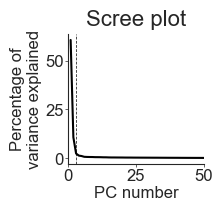

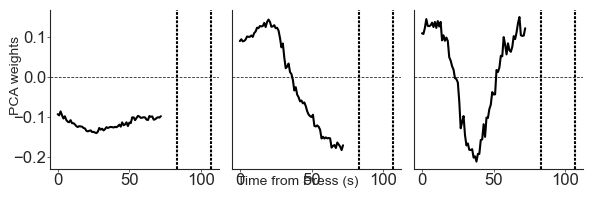

In [323]:
load_savedpca_or_dopca = 'dopca' #select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(models, 'PCA_ACQ.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(models, 'PCA_ACQ.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
np.save(os.path.join(models, 'PCA_ACQ_transformed-data.npy'), transformed_data)
transformed_data = np.load(os.path.join(models, 'PCA_ACQ_transformed-data.npy'))

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
print(x)
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by siplty bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
ax.set_xlim([0,50])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['Active-Inactive'] = (0,0,0) 
# colors_for_key['Inactive'] = (0.5,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey], label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
    ax.axvline(pre_window_size+int(framerate*3), linestyle='--', color='k', linewidth=1.5)
    ax.axhline(0, linestyle='--', color='k', linewidth=0.5)
    #ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction', #FIXME
    #            textcoords='axes fraction', multialignment='center', size='large')
#     if pc >= num_retained_pcs-numcols:
#         ax.set_xticks([0, pre_window_size,
#                        infusionframe, window_size])
#         ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
#                              for a in [0, pre_window_size,
#                                        infusionframe, window_size]])
#     else:
#         ax.set_xticks([])
#         ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from Press (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

# fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT PCs.PDF'), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT PCs.png'), format='PNG')


In [324]:
#clustering

max_n_clusters = 10 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([197, 394, 591, 788, 985, 1182, 1379, 1576, 1773, 1970]) # This should be selected for each dataset
# appropriately. When 1511 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data. [500, 1000, 1500,  2500, 3000, 3500, 4000, 4500, 5000, 5500]
      
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters, nn, silhouette_scores[n_clustersidx, nnidx]))

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(models, 'silhouette_scores_ACQ.pickle'), 'wb') as f:
    pickle.dump(temp, f)   
    

Done with numclusters = 2, num nearest neighbors = 197: score = 0.412
Done with numclusters = 2, num nearest neighbors = 394: score = 0.415
Done with numclusters = 2, num nearest neighbors = 591: score = 0.431
Done with numclusters = 2, num nearest neighbors = 788: score = 0.448
Done with numclusters = 2, num nearest neighbors = 985: score = 0.463
Done with numclusters = 2, num nearest neighbors = 1182: score = 0.467
Done with numclusters = 2, num nearest neighbors = 1379: score = 0.469
Done with numclusters = 2, num nearest neighbors = 1576: score = 0.469
Done with numclusters = 2, num nearest neighbors = 1773: score = 0.452
Done with numclusters = 2, num nearest neighbors = 1970: score = 0.444
Done with numclusters = 3, num nearest neighbors = 197: score = 0.436
Done with numclusters = 3, num nearest neighbors = 394: score = 0.433
Done with numclusters = 3, num nearest neighbors = 591: score = 0.454
Done with numclusters = 3, num nearest neighbors = 788: score = 0.478
Done with numcl

In [325]:
with open(os.path.join(models, 'silhouette_scores_ACQ.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = np.load(os.path.join(models, 'PCA_ACQ_transformed-data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print ('Num clusters:', n_clusters)
print('Num nearest neighbors:', n_nearest_neighbors)

#redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=n_nearest_neighbors)

#different forms of clustering
# model = KMeans(n_clusters=n_clusters, algorithm = 'elkan')
# model = AgglomerativeClustering(n_clusters=n_clusters)

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

#save this optimal clustering model.
with open(os.path.join(models, 'PFC_SA_clusteringmodel.pickle'), 'wb') as f:
    pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

#create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

colors_for_cluster = [[0.933, 0.250, 0.211],[0.941, 0.352, 0.156],[0.964, 0.572, 0.117],[0.980, 0.686, 0.250],[0.545, 0.772, 0.247],[0.215, 0.701, 0.290],[0, 0.576, 0.270],[0, 0.650, 0.611],[0.145, 0.662, 0.878]]

np.save(os.path.join(models, 'clusterlabels_ACQ.npy'), newlabels)
##ONLY USE IF YOU WANT TO OVERWRITE EXISTING, SAVED CLUSTERING DATA

Num clusters: 3
Num nearest neighbors: 1379
Number of clusters = 3, average silhouette = 0.503


c:\Users\jboqu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jboqu\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [326]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this exaplte all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each saplte
    saplte_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine') #FIXME: saptle???

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for sapltes belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            saplte_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 sapltes

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    #fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT Silhouettes.PDF'), format='PDF')
    #fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT Silhouettes.PNG'), format='PNG')

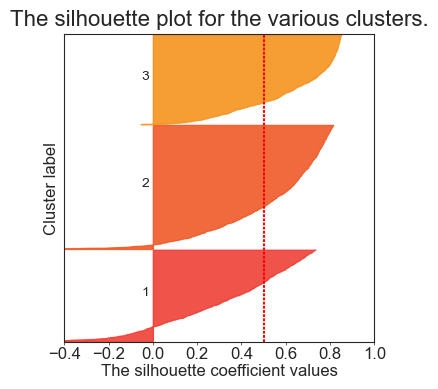

In [327]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

### Plotting clusters

In [338]:
####This section saves cluster IDs to each FOV Folder for future use. 
####DO NOT RUN/SAVE UNLESS YOU WANT TO OVERWRITE CLUSTER LISTS

cluster_id_list = newlabels
print('cluster id list shape:', cluster_id_list.shape)

cellcounter = 0

##Assign cluster IDs to neurons within early animals of interest
for animal in early_animals_used:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
        np.save(os.path.join(models, 'cluster_list_per_fov_EARLY_ACQ.npy'), neuron_id_list)
firstcellearly = 0
lastcellearly = cellcounter
np.save(os.path.join(models, 'cluster_list_per_session_EARLY_ACQ.npy'), newlabels[firstcellearly:lastcellearly])
print('EARLY:', newlabels[firstcellearly:lastcellearly].shape)

##Assign cluster IDs to neurons within middle animals of interest
for animal in middle_animals_used:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
        np.save(os.path.join(models,'cluster_list_per_fov_MIDDLE_ACQ.npy'), neuron_id_list)
firstcellmiddle = 0
lastcellmiddle = cellcounter
np.save(os.path.join(models, 'cluster_list_per_session_MIDDLE_ACQ.npy'), newlabels[firstcellearly:lastcellearly])
print('MIDDLE:', newlabels[firstcellearly:lastcellearly].shape)
       
###Assign cluster IDs to neurons within late animals of interest
for animal in late_animals_used:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
        np.save(os.path.join(models, 'cluster_list_per_fov_LATE_ACQ.npy'), neuron_id_list)
firstcelllate = 0
lastcelllate = cellcounter
np.save(os.path.join(models, 'cluster_list_per_session_LATE_ACQ.npy'), newlabels[firstcellearly:lastcellearly])
print('LATE:', newlabels[firstcellearly:lastcellearly].shape)


cluster id list shape: (3952,)
EARLY: (614,)
MIDDLE: (614,)
LATE: (614,)


In [342]:
#initializing data
early_populationdata = early_active
middle_populationdata = middle_active
late_populationdata = late_active
all_populationdata = np.vstack((early_active, middle_active, late_active))

#num neurons
early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

print('Early population num neurons:', early_numneurons)
print('Middle population num neurons:', middle_numneurons)
print('Late population num neurons:', late_numneurons)
print('All population num neurons:', all_numneurons)
print()

#cluster list files
early_newlabels = np.load(os.path.join(earlybasedir, 'cluster_list_per_session_Acquisition.npy')) #put clustering files in a folder to loop through
middle_newlabels = np.load(os.path.join(middlebasedir, 'cluster_list_per_session_Acquisition.npy'))
late_newlabels = np.load(os.path.join(latebasedir, 'cluster_list_per_session_Acquisition.npy'))

#limiting indexing to only values in original file up to the amount of neurons used
early_newlabels = early_newlabels[:early_numneurons] 
middle_newlabels = middle_newlabels[:middle_numneurons]
late_newlabels = late_newlabels[:late_numneurons]
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

#the label values should match the num of neurons
print('Early labels shape:', early_newlabels.shape)
print('Middle labels shape:', middle_newlabels.shape)
print('Late labels shape:', late_newlabels.shape)
print('All labels shape:', all_newlabels.shape)


Early population num neurons: 614
Middle population num neurons: 1168
Late population num neurons: 194
All population num neurons: 1976

Early labels shape: (614,)
Middle labels shape: (1168,)
Late labels shape: (194,)
All labels shape: (1976,)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_16364\1387368244.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


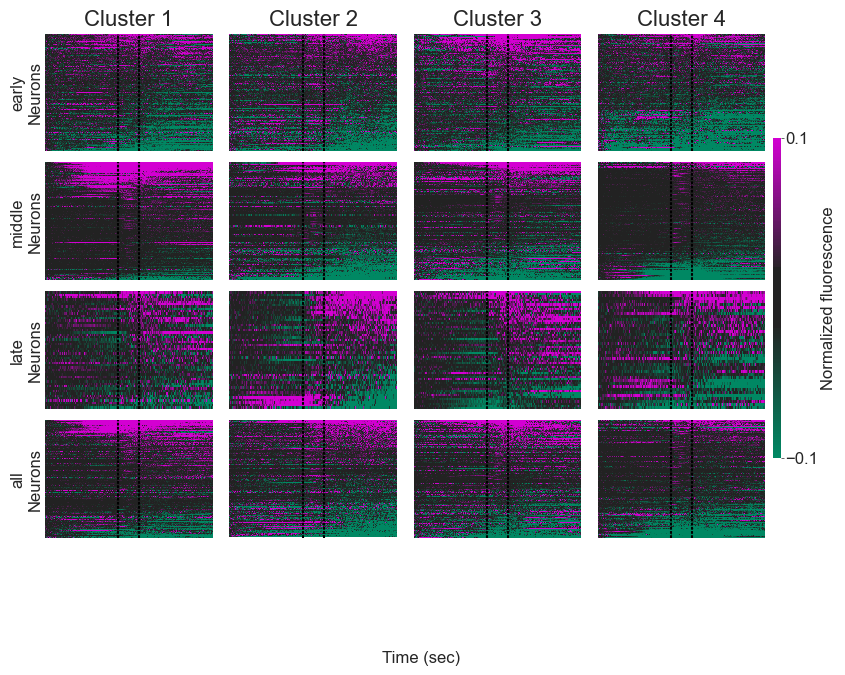

In [340]:
sessions = ['early', 'middle', 'late', 'all'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for c, cluster in enumerate(uniquelabels):
    sortwindow[c] = {}
    if c == 0:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 1:
        sortwindow[c] = [infusionframe+int(1*framerate), -1]
    if c == 2:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 3:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[c][0]:sortwindow[c][1]], axis=1))[::-1]
        hm = sns.heatmap(
                    temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axvline(infusionframe, linestyle='--', color='k', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

# fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT, NoCueOnly Ensemble Heatmaps.PDF'), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT, NoCueOnly Ensemble Heatmaps.png'), format='PNG')



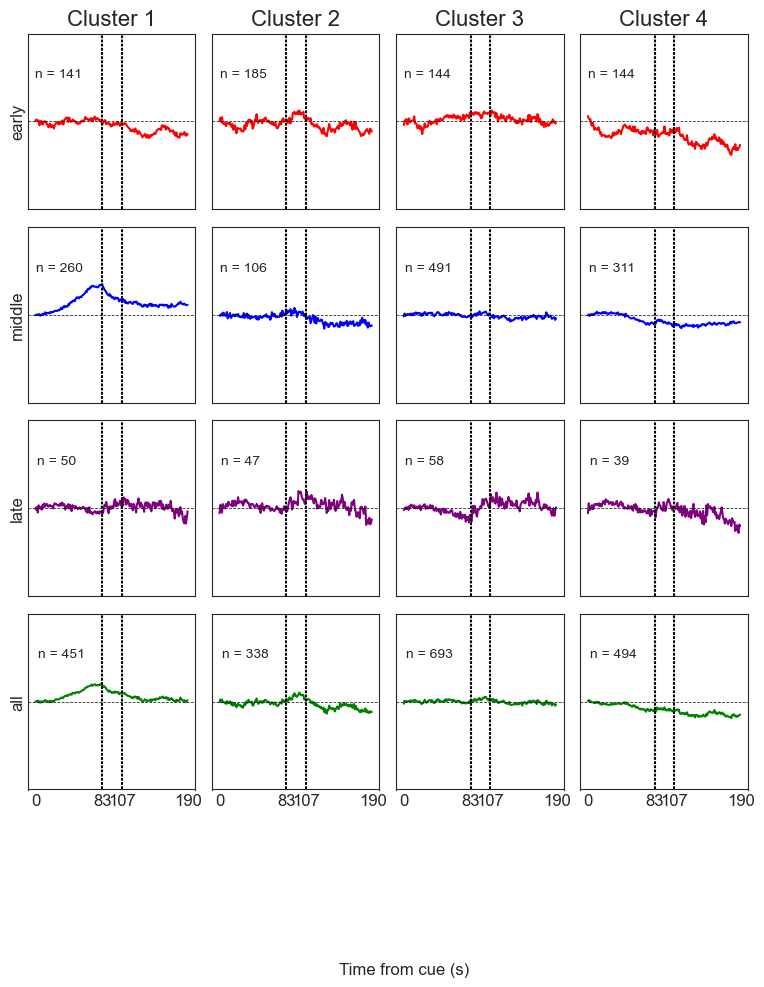

In [341]:
fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numroisincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
        numroisincluster[c] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, c])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.2, .2))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numroisincluster[c]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axvline(infusionframe, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

# fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT, NoCueOnly Ensemble Lines.PDF'), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT, NoCueOnly Ensemble Lines.png'), format='PNG')
